#### Outlier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('data/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


In [4]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


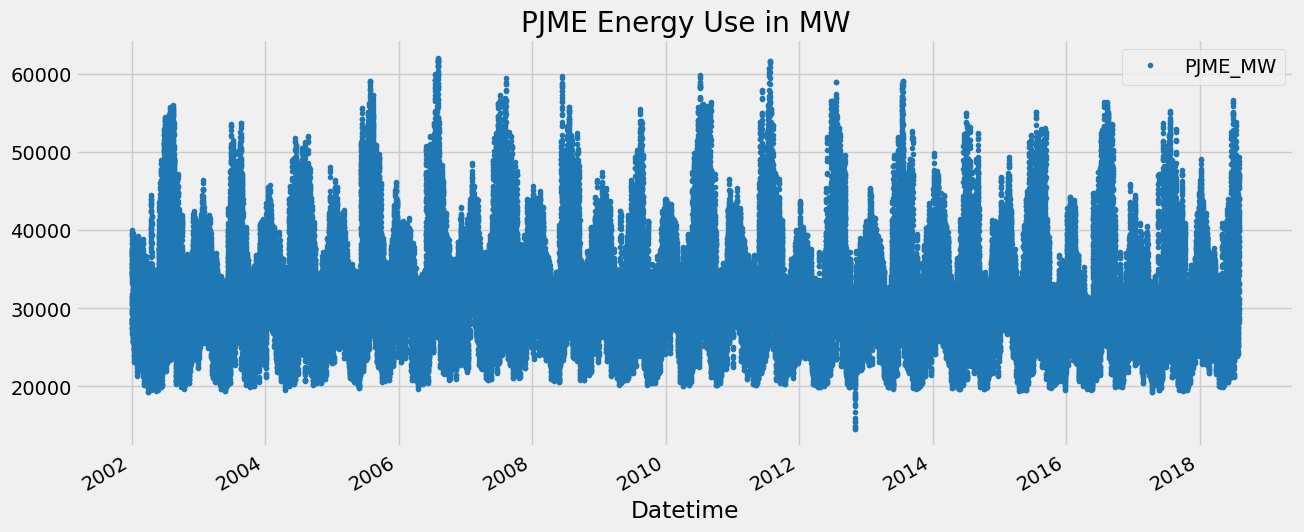

In [5]:
df.plot(style='.',
        figsize=(14,6),
        color=color_pal[0],
        title = 'PJME Energy Use in MW')
plt.show()

In [6]:
df.index.max(), df.index.min()

(Timestamp('2018-08-03 00:00:00'), Timestamp('2002-01-01 01:00:00'))

In [7]:
df.shape

(145366, 1)

<Axes: ylabel='Frequency'>

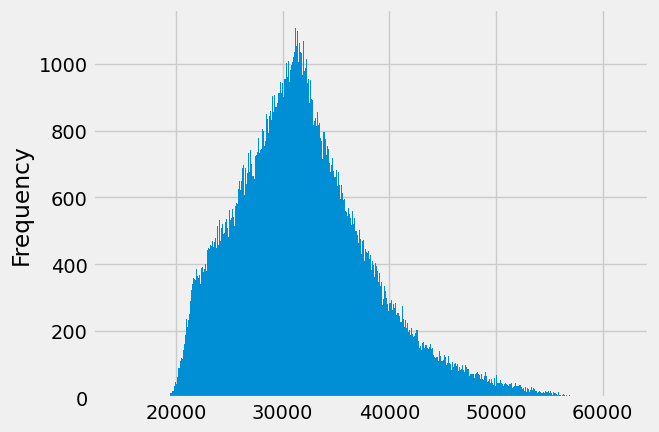

In [9]:
df['PJME_MW'].plot(kind='hist', bins = 500)

<Axes: xlabel='Datetime'>

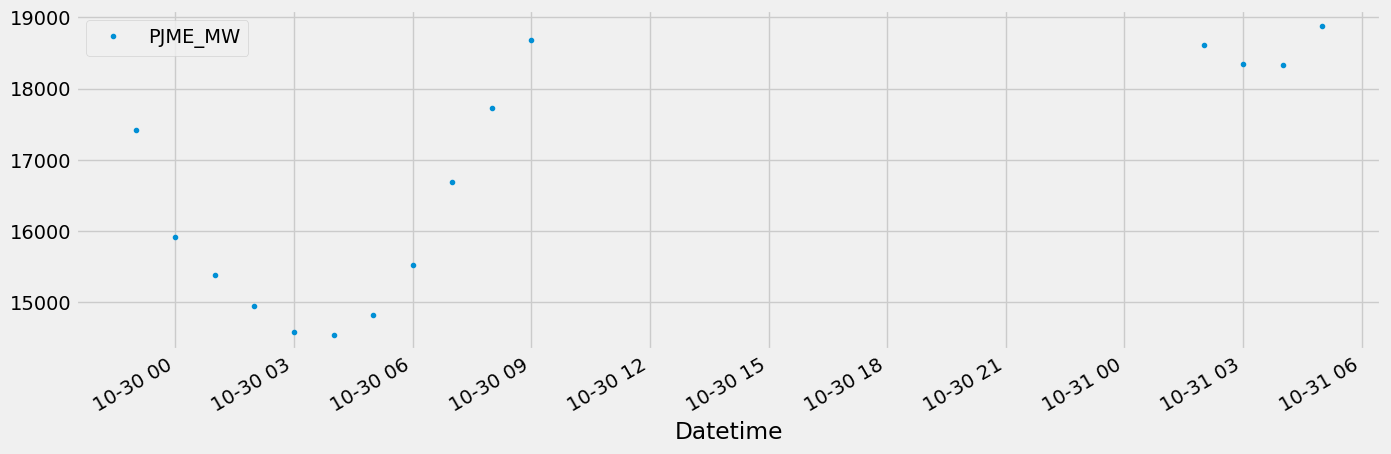

In [11]:
df.query('PJME_MW <19_000').plot(figsize=(15,5), style = '.')

In [12]:
df = df.query('PJME_MW > 19_000').copy()

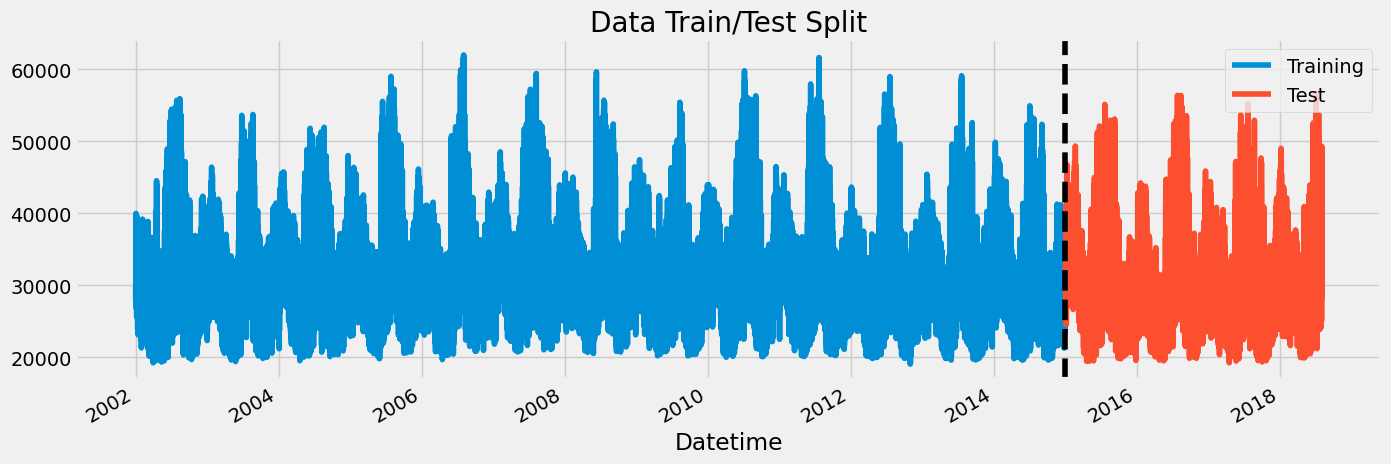

In [16]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))

train.plot(ax = ax, label = 'Training', title = 'Data Train/Test Split')
test.plot(ax = ax, label = 'Test')

ax.axvline('01-01-2015', color='black', ls = '--')
ax.legend(['Training', 'Test'])

plt.show()

### Time Series Cross Validation

In [17]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

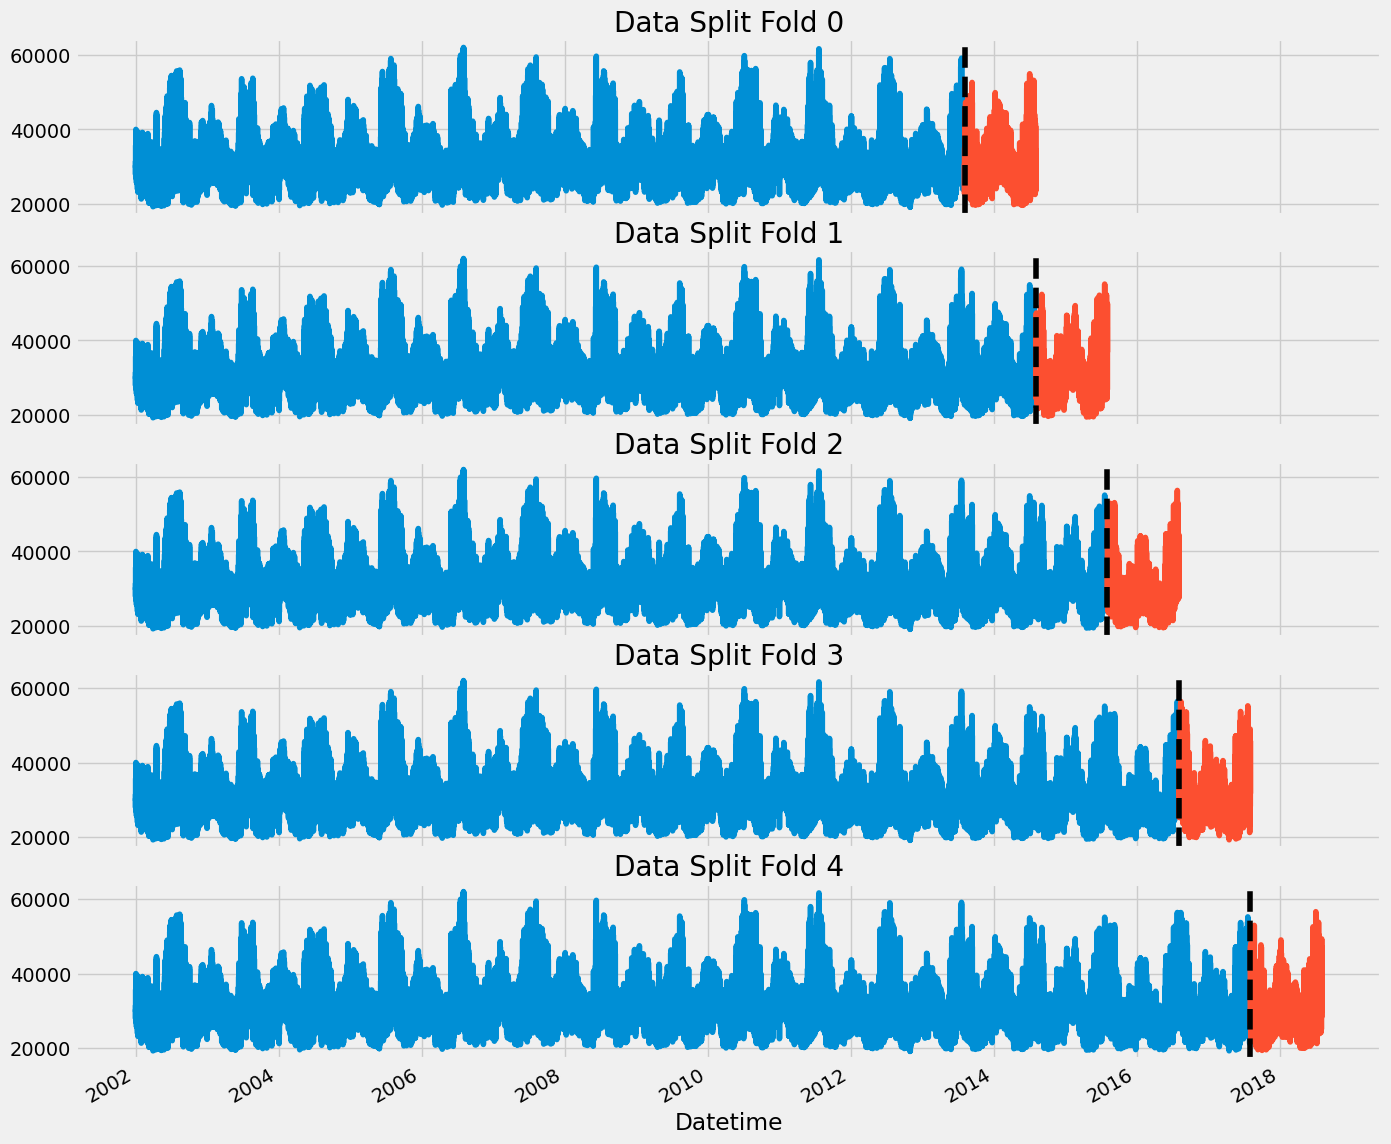

In [22]:
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex = True)

fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold], 
                          label = 'Training', 
                          title = f'Data Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold], label = 'Test')
    axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
    fold += 1

In [23]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [24]:
# Lag Features
# What was the target (x) days in the past

In [26]:
target_map = df['PJME_MW'].to_dict()

In [29]:
df.index - pd.Timedelta('364 days')

DatetimeIndex(['2001-01-02 01:00:00', '2001-01-02 02:00:00',
               '2001-01-02 03:00:00', '2001-01-02 04:00:00',
               '2001-01-02 05:00:00', '2001-01-02 06:00:00',
               '2001-01-02 07:00:00', '2001-01-02 08:00:00',
               '2001-01-02 09:00:00', '2001-01-02 10:00:00',
               ...
               '2017-08-03 15:00:00', '2017-08-03 16:00:00',
               '2017-08-03 17:00:00', '2017-08-03 18:00:00',
               '2017-08-03 19:00:00', '2017-08-03 20:00:00',
               '2017-08-03 21:00:00', '2017-08-03 22:00:00',
               '2017-08-03 23:00:00', '2017-08-04 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145351, freq=None)

In [30]:
(df.index - pd.Timedelta('364 days')).map(target_map)

Index([    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,
       ...
       46462.0, 47318.0, 47490.0, 46436.0, 44429.0, 42256.0, 41210.0, 39525.0,
       36490.0, 33539.0],
      dtype='float64', name='Datetime', length=145351)

In [31]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [32]:
df = add_lags(df)

In [34]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0


In [35]:
### Training on different folds, and use lag1, lag2 and lag3 as additional features

In [36]:
tse = TimeSeriesSplit(n_splits=5, test_size = 24*365*1, gap = 24)
df = df.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
                'lag1', 'lag2', 'lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score = 0.5,
                           booster = 'gbtree',
                           n_estimators = 1000,
                           early_stopping_rounds = 50,
                           objective = 'reg:linear',
                           max_depth = 3,
                           learning_rate = 0.01)
    
    reg.fit(X_train, y_train,
            eval_set = [(X_train, y_train), (X_test, y_test)],
            verbose = 100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


c:\Users\haode\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:25:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[442]	validation_0-rmse:3369.34730	validation_1-rmse:3764.82810
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


c:\Users\haode\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:25:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.31309
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


c:\Users\haode\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:25:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.70202
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.22087
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.46419
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.32356
[410]	validation_0-rmse:3476.66883	validation_1-rmse:3502.25535
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


c:\Users\haode\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:25:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.36581	validation_1-rmse:12020.28283
[200]	validation_0-rmse:5738.57925	validation_1-rmse:5796.45874
[300]	validation_0-rmse:3918.53218	validation_1-rmse:4388.39477
[400]	validation_0-rmse:3501.24270	validation_1-rmse:4173.36380
[500]	validation_0-rmse:3384.02490	validation_1-rmse:4119.56538
[600]	validation_0-rmse:3325.50024	validation_1-rmse:4105.01446
[700]	validation_0-rmse:3282.73755	validation_1-rmse:4091.23557
[800]	validation_0-rmse:3250.37610	validation_1-rmse:4083.12690
[900]	validation_0-rmse:3223.87814	validation_1-rmse:4081.46154
[999]	validation_0-rmse:3199.82843	validation_1-rmse:4052.57120
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


c:\Users\haode\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:25:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.87740	validation_1-rmse:11963.42706
[200]	validation_0-rmse:5752.44568	validation_1-rmse:5611.92884
[300]	validation_0-rmse:3951.51709	validation_1-rmse:4156.41403
[400]	validation_0-rmse:3539.25569	validation_1-rmse:4006.58873
[439]	validation_0-rmse:3480.87364	validation_1-rmse:4011.68406


In [37]:
scores

[3760.8277187583353,
 3420.313091887879,
 3478.018038580526,
 4052.5712055405547,
 4001.186553933809]

In [38]:
print(f'MSE across folds is {np.mean(scores):0.4f}')

MSE across folds is 3742.5833


In [41]:
np.mean(scores)

3742.5833217402205

In [43]:
## Predicting the Future

# Retraining on all data
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1', 'lag2', 'lag3']
TARGET = 'PJME_MW'

X_train = df[FEATURES]
y_train = df[TARGET]

# X_test = test[FEATURES]
# y_test = test[TARGET]

reg = xgb.XGBRegressor(base_score = 0.5,
                        booster = 'gbtree',
                        n_estimators = 500,
                        early_stopping_rounds = 50,
                        objective = 'reg:linear',
                        max_depth = 3,
                        learning_rate = 0.01)

reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train)],
        verbose = 100)


[0]	validation_0-rmse:32403.88991


c:\Users\haode\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:39:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.83220
[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[499]	validation_0-rmse:3456.76877


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [44]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [48]:
# create future time frame
future = pd.date_range('2018-08-03', '2019-08-01', freq = '1h')
future_df = pd.DataFrame(index=future)

future_df['isFuture'] = True
df['isFuture'] = False

df_and_Future = pd.concat([df, future_df])
df_and_Future = create_features(df_and_Future)
df_and_Future = add_lags(df_and_Future)

df_and_Future

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


In [49]:
future_w_features = df_and_Future.query('isFuture').copy()
future_w_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


In [50]:
# Predict the future features
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

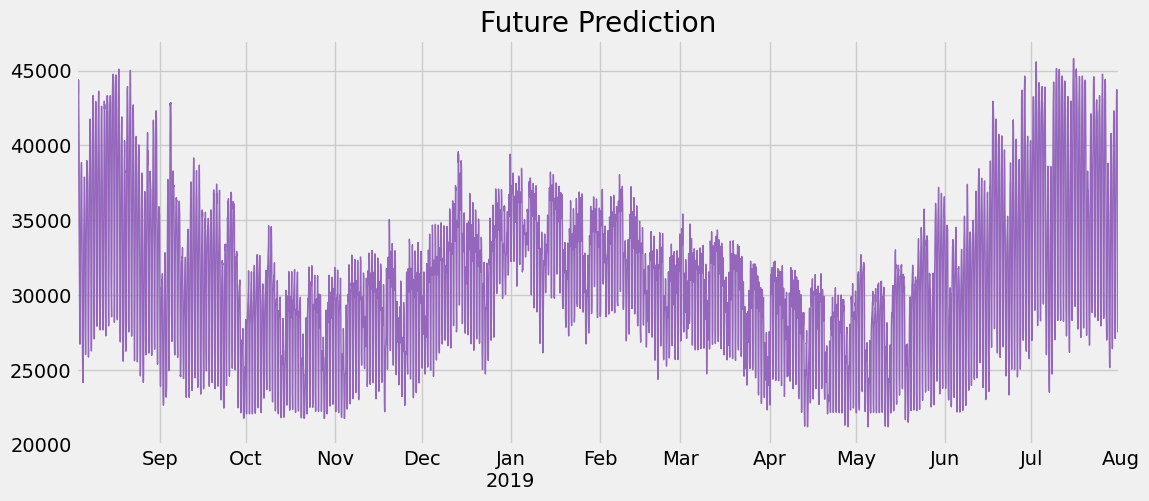

In [52]:
future_w_features['pred'].plot(figsize=(12,5),
                               color = color_pal[4],
                               ms=1, lw=1, title = 'Future Prediction')

plt.show()

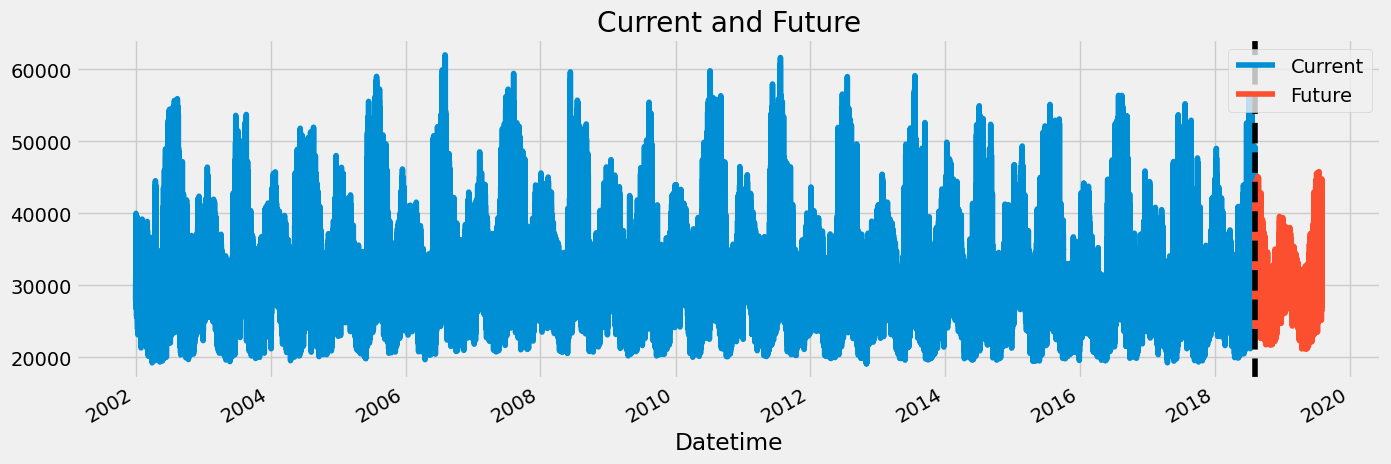

In [58]:
fig, ax = plt.subplots(figsize=(15,5))

df['PJME_MW'].plot(ax = ax, label = 'Current', title = 'Current and Future')
future_w_features['pred'].plot(ax = ax,
                            #    color = color_pal[4],
                                label = 'Future',
                            #    ms=1, lw=1,
                               )
#test.plot(ax = ax, label = 'Test')

ax.axvline('08-03-2018', color='black', ls = '--')
ax.legend(['Current', 'Future'])

plt.show()

In [59]:
# Save model
reg.save_model('model.json')

In [60]:
!ls -lh

'ls' is not recognized as an internal or external command,
operable program or batch file.
